In [1]:
import os
os.chdir('D:\\Ранх учеба\\3 курс\\Колметоды\\')
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5) #set default figure size
import numpy as np
import pandas as pd
# from numba import njit, float64, jit
# from numba.experimental import jitclass
from quantecon.distributions import BetaBinomial
import seaborn as sns

# A-D-V-A-N-C-E-D 
модель для работяг + задание из первой части, тут вперемешку

## Теория

Основные пункты из проекта:
1. ЦБ:
* минимизирует инфляцию
2. Государство:
* минимизирует безработицу путем минимизации резервной заработной платы
* поэтому запрещает увольнять и увольняться (нулевая вероятность увольнения)
* может управлять размером пособия по безработице, для финансирования которого печатает деньги

Ставка ЦБ задается по правилу:
<p style="text-align: center;">$r = \mu * \frac {новое\ пособие}{старое\ пособие}$</p>,
где $\mu$ по изначальному предположению = 0.05

**Задача**:
Имея размер старого пособия, найти оптимальный размер нового пособия в смысле минимизации резервной заработной платы. Решение связать с дисконт-фактором и кучей других экзогенно заданных параметров.

**Тестирование**:
"Для проверки эффективности своей политики государство берет случайного человека и смотрит на него на протяжении 100 периодов. Если он не работает, каждый период ему делают оффер со случайной зарплатой из вашего распределения.
1. Сколько в среднем о будет не работать при новом размере пособия? В прошлом такие эксперименты государством проводились.
2. Сколько бы в среднем не работал человек при старом пособии?
3. Нарисуйте график средней продолжительности безработицы, где по абсциссе лежат пособия от нового до старого. 
4. Сколько бы в среднем не работал человек при старом пособии и ненулевой вероятности увольнения? Что скажете о политике государства?"

Как можно посчитать **дисконт-фактор**?<br>

 Какие у нас есть риски, которые влияют на дисконтирование доходов:
1. Инфляция (одинаковый доход в будущем и сейчас ценится по разному). <br>
В модели Маккола это была patience (или, корректнее, impatience).
2. Риск увольнения. <br>
Этот риск влияет на мое решение о резервной зп, но связан ли он с будущим (или моими предпочтениями относительно будущего)??<br>
Если я считаю, что вероятность моего увольнения в следующем году велика, то мне тогда остается как можно больше зафармить за текущий год. При том, что объективно стоимость денег снижается на уровне инфляции, доход в этом году мне более важен, поскольку я считаю, что в следующем году у меня уже не будет текущей работы. <br>
Тем не менее логика очень слабая, поэтому в модель добавлять ее не буду.

Есть и другие риски для агента (например, возможность пропустить оффер, будучи занятым), но они относятся к оптимальному решению по резервной зп, но не к дисконтированию доходов. Также важно понимать, что наличие этих рисков не влияет на вид оптимизационной задачи, поскольку агент не может воздействовать на ставку процента и риск увольнения.

Пусть 
<p style="text-align: center;">$\beta$ (ставка дисконта) = 1 - $r$ (уровень инфляции). </p> <br> *Формула выведена подбором и не соответствует действительности.* <br>

Что взять в качестве **пособия по безработице**?<br>
[Постановление Правительства РФ от 24.11.2017 N 1423](http://publication.pravo.gov.ru/Document/View/0001201811190008) - максимальный размер пособия для обычных людей равен 8000 рублей, минимальный - 1500. Россия - щедрая страна, поэтому предположим, что многие безработные получали 8000 при оформлении пособия.

Во многих экономических исследованиях берется **CRRA** (Constant Relative Risk Aversion - постоянное относительное непринятие риска) **utility**, то бишь изоэластичная функция полезности (предпосылка об изоэластичности предпочтений у агентов, в частности, позволяет использовать OLS в моделях с эндогенностью - см. A CONTRIBUTION TO THE EMPIRICS OF ECONOMIC GROWTH, p.5). Задается она следующим образом:

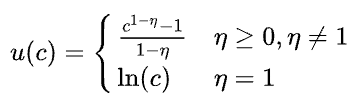

## Обсуждение 

Если изначально модель Макколла была про работника и принимаемые им решения, то теперь мы оказываемся на стороне государства, которое озабочено снижением уровня безработицы. При этом, если мы знаем, как поведет себя агент Макколла, то мы сможем по идее провести ту политику, которую мы задумываем.

Первым, о чем я подумал: можем ли мы просто занулить пособие? Чем ниже пособие, тем ниже резервная зп. Оказывается, не так просто.

In [2]:
'''
Рандомное распределение зарплат
'''
n = 60 # n possible outcomes for w
w_default = np.linspace(10, 20, n) # wages between 10 and 20
a, b = 600, 400 # shape parameters
dist = BetaBinomial(n-1, a, b)
q_default = dist.pdf()

In [3]:

class McCallModel:
    """
    Создание класса "удобно" для хранения параметров модели, а также методов, которые будут
    использоваться для вычисления оптимальных политик.
    """
    
    def __init__(self, α, #=0.2, 
                 β, #=0.98, 
                 c, #=6.0, 
                 w=w_default, q=q_default):
        self.α, self.β, self.c, self.w, self.q = α, β, c, w, q
        
    def update(self, v, d):
        α, β, c, w, q = self.α, self.β, self.c, self.w, self.q
        v_new = np.empty_like(v)
        for i in range(len(w)):
            v_new[i] = u(w[i]) + β * ((1 - α) * v[i] + α * d)
            
        d_new = np.sum(np.maximum(v, u(c) + β * d) * q)
        return v_new, d_new
    def state_action_values(self, i, v):
        
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # подсчитываем значения
        # приходим к выбору = принять или отклонить оффер
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)
        
        return np.array([accept, reject])

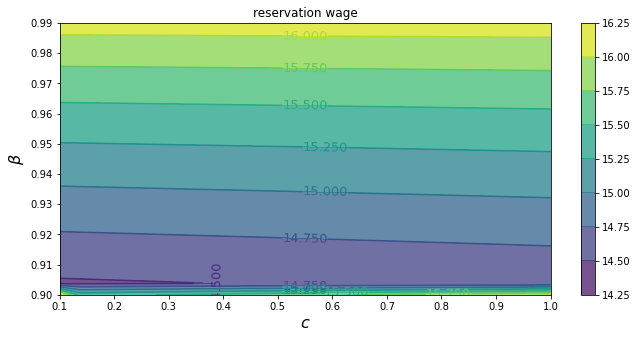

In [4]:
"""
Эта функция вычисляет резервную зп для простой модели Маккола,
в которой нет возомжности уволиться и без функции полезности. Тем не менее она нам понадобится для рисунка.
Итерируем, пока не сдохнем (кончатся периоды), либо пока погрешность не станет незначительной.
"""
def compute_reservation_wage1(mcm,
    max_iter=1000, tol=1e-6):
    
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q
    
    # Начальное v
    n = len(w)
    v = w / (1 - β) 
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:
        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))
            error = np.max(np.abs(v_next - v))
            i += 1
            v[:] = v_next 
            # Подсчет резервной зп
    return (1 - β) * (c + β * np.sum(v * q))




grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(.1, 1, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β, α=0.2)
        R[i, j] = compute_reservation_wage1(mcm)

fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)

ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)
ax.ticklabel_format(useOffset=False)

plt.show()

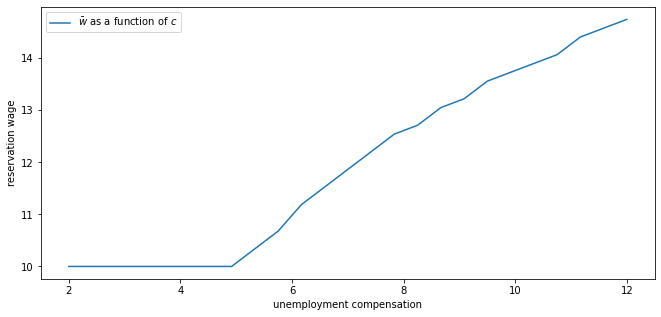

In [8]:
mcm = McCallModel(c=6, β=0.9, α=0.2)

# Функция полезности, о которой говорилось выше.
def u(c, σ=2.0):
    if σ != 1:
        return (c**(1 - σ) - 1) / (1 - σ)
    elif σ >= 0 :
        return np.log(c)

grid_size = 25
c_vals = np.linspace(2, 12, grid_size)
beta_vals = np.linspace(0.8, 0.99, grid_size)
alpha_vals = np.linspace(0.05, 0.5, grid_size)

w_bar_vals = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, c in enumerate(c_vals):
    mcm.c = c
    w_bar = compute_reservation_wage(mcm) # функция для подсчета резервной зп из блока выше
    w_bar_vals[i] = w_bar

ax.set(xlabel='unemployment compensation',
ylabel='reservation wage')
ax.plot(c_vals, w_bar_vals, label=r'$\bar w$ as a function of $c$')
ax.legend()
plt.show()

Функция резервной заработной платы зависит не только от $c$, но и от $\beta$. В какой-то момент $\overline{w}$ становится просто неэластичной по безработному пособию, что можно увидеть по картинкам выше. <br>
К этому выводу можно было прийти и аналитически: ниже пособие -> выше $r$ -> выше ставка дисконтирования $\beta$ -> агенту важны будущие доходы, и ему становится выгоднее подождать.

В каком виде я представляю себе **решение** (в моем понимании это выглядит так):

<p style="text-align: center;"> $min\ \overline{w}$</p>

s.t.
1. агент пытается максимизировать
<p style="text-align: center;">$\mathbb{E}\sum_{t=0}^∞ {\beta^tu(y_t)}$</p>
2. Имеет следующие целевые функции
<p style="text-align: center;">$v(w_e) = u(w_e) + \beta[(1-\alpha) v(w_e) + \alpha\sum_{w'\in\mathbb{W}}h(w')q(w')]$</p> 
<p style="text-align: center;">$h(w)=max\{v(w), u(c) + \beta\sum_{w'\in\mathbb{W}}h(w')q(w')\}$,</p>
где
* $v(w_e)$ - значение функции значения (ну и бред; другими словами - total lifetime value accruing to a worker - общая стоимость доходов, получаемых в течение жизни) работника, который на текущий момент времени имеет зарплату $w_e$
* $h(w)$  - общая стоимость доходов работника, который на текущий момент безработен и получает оффер $w$ <br>

которые после упрощения 
<p style="text-align: center;">$d:= \sum_{w'\in\mathbb{W}}h(w')q(w')$</p>
принимают вид
<p style="text-align: center;">$h(w) = max\{v(w), u(c) + \beta d\}$</p>
<p style="text-align: center;">$v(w) = u(w) + \beta [(1-\alpha)v(w) + \alpha d]$</p>
Здесь $h(w)$ избавлен от реккурентности, поэтому работник решает задачу для $d$ и $v$

<p style="text-align: center;">$d = \sum_{w'\in\mathbb{W}}max\{v(w), u(c) + \beta d\}q(w')$</p>
<p style="text-align: center;">$v(w) = u(w) + \beta [(1-\alpha)v(w) + \alpha d]$</p>


Как это реализовать:

Не специалист в решении оптимизационно-алгоритмических задач, но по аналогии с тем, что было, можно попробовать также решить в динамике:
1. Имеем старое значение пособия; формируем остальные экзогенные параметры и высчитываем эндогенные
2. Смотрим на размер резервной зп Wage
3. Берем другое значение пособия по специальной оптимизационной технике ситхов; также формируем и высчитываем
4. Смотрим на Wage'
5. Если |Wage' - Wage| < tol, оставляем значение как приблизительную аппроксимацию, иначе возврат к п.3.


**Сначала возьмем синтетические данные, потом апробируем на реальных.**

In [9]:
# Функция полезности

def u(c, σ=2.0):
    if σ != 1:
        return (c**(1 - σ) - 1) / (1 - σ)
    elif σ >= 0 :
        return np.log(c)

In [10]:
# Распределение зпшек

n = 60 # Set of w
w_default = np.linspace(10, 20, n) # W support
a, b = 600, 400 # parameters of distribution
dist = BetaBinomial(n-1, a, b)
q_default = dist.pdf()

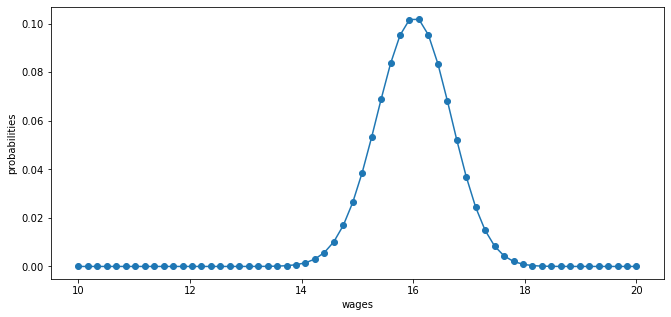

In [11]:
# График распределения 

fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')
plt.show()

In [12]:
'''
Решение модели: расчет вектора значений v (кривая) и числа d, на основе которого строится прямая h
Пересечение v и h на графике дает уровень резервной зп
'''

def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Последовательно сходимся к решению уравнения Беллмана
    Формулы для v и d были написаны выше
    """
    
    v = np.ones_like(mcm.w) # Начальное значение v
    d = 1 # Начальное значение d
    i = 0
    error = tol + 1
    while error > tol and i < max_iter:
        v_new, d_new = mcm.update(v, d)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(d_new - d)
        error = max(error_1, error_2)
        v = v_new
        d = d_new
        i += 1
        
    return v, d

In [13]:
def compute_reservation_wage(mcm):
    """
    Подсчитываем уровень резервной зп для модели с определенными параметрами,
    подбирая такоe w, что v(w) >= h
    Если такой зп не существует,то w_bar = inf
    """
    
    v, d = solve_model(mcm)
    h = u(mcm.c) + mcm.β * d
    w_bar = np.inf
    for i, wage in enumerate(mcm.w):
        if v[i] > h:
            w_bar = wage
            break
    return w_bar

**Решение может существовать не всегда**

Я пишу это на случай, если захочется потестировать.

В частности, его может не быть при больших $\alpha$:

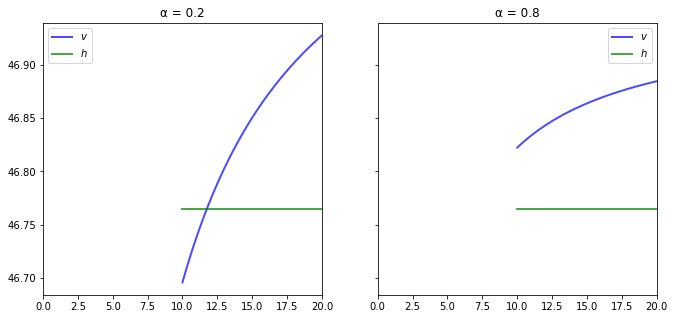

In [14]:
mcm = McCallModel(α=.2, β=0.98, c=6)

v, d = solve_model(mcm)
h = u(mcm.c) + mcm.β * d

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(mcm.w, v, 'b-', lw=2, alpha=0.7, label='$v$')
ax1.plot(mcm.w, [h] * len(mcm.w),
    'g-', lw=2, alpha=0.7, label='$h$')

mcm = McCallModel(α=.8, β=0.98, c=6)

v, d = solve_model(mcm)
h = u(mcm.c) + mcm.β * d
ax2.plot(mcm.w, v, 'b-', lw=2, alpha=0.7, label='$v$')
ax2.plot(mcm.w, [h] * len(mcm.w),
    'g-', lw=2, alpha=0.7, label='$h$')

ax1.set_xlim(0, max(mcm.w))
ax1.title.set_text('α = 0.2')
ax1.legend()
ax2.set_xlim(0, max(mcm.w))
ax2.title.set_text('α = 0.8')
ax2.legend()

plt.show()

Или при слишком больших пособиях $c$.

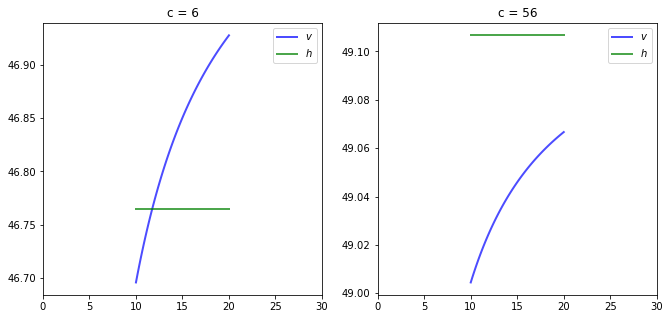

In [15]:
mcm = McCallModel(α=.2, β=0.98, c=6)

v, d = solve_model(mcm)
h = u(mcm.c) + mcm.β * d

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

ax1.plot(mcm.w, v, 'b-', lw=2, alpha=0.7, label='$v$')
ax1.plot(mcm.w, [h] * len(mcm.w),
    'g-', lw=2, alpha=0.7, label='$h$');

mcm = McCallModel(α=.8, β=0.98, c=56)

v, d = solve_model(mcm)
h = u(mcm.c) + mcm.β * d
ax2.plot(mcm.w, v, 'b-', lw=2, alpha=0.7, label='$v$')
ax2.plot(mcm.w, [h] * len(mcm.w),
    'g-', lw=2, alpha=0.7, label='$h$')

ax1.set_xlim(0, max(mcm.w) + 10)
ax1.title.set_text('c = 6')
ax1.legend()
ax2.set_xlim(0, max(mcm.w) + 10)
ax2.title.set_text('c = 56')
ax2.legend()

plt.show()

То есть пересечение линий уже будет вне диапазона зарплат.

## Реализация решений (тестовые данные)

In [16]:
periods = 100 # living duration
attempts = 100 # number of iterations
max_w, min_w  = max(w_default), min(w_default)
tol = (max_w + min_w)/1000 # tolerance
step = (max_w + min_w)/10 # step for gradient descent

c = 6 # inital guess of compensation
μ = 0.05; r = 0.1; α = 0.02 # initial values

'''
Здесь чисто вручную прописанная оптимизация с изменением параметров
Градиентный спуск без градиента. Просто двигаемся влево-вправо и ищем наименьшее значение
'''
def solving(α, c, periods = periods, attempts = attempts, tol = tol,
           μ=μ, r=r, step = step):
    
    # начальное предположение о резервной зп
    old_wage = compute_reservation_wage(McCallModel(c=c, β = 1 - (r), α=α))
    attempt, error = 0, np.inf
    
    # итерируем и флексим, пока сходится
    while attempt <= attempts and error > tol:
        # движ вправо
        new_c = c + step; 
        r = μ * new_c / c
        β = 1 - (r)
        new_wage = compute_reservation_wage(McCallModel(c=new_c, β=β, α=α))
        diff = new_wage - old_wage
#         print(new_wage)
        
        if diff > 0:
            # new_wage > old_wage (движ влево)
            new_c = c - step;
            r = μ * new_c / c
            β = 1 - (r)
#             print(β)
            new_wage = compute_reservation_wage(McCallModel(c=new_c, β=β, α=α))
#             print(new_wage)
            
        if min(new_wage, old_wage) == old_wage:
            step /= 2
        
        error = abs(new_c - c)
#         print('wage :', [old_wage, new_wage])
#         print('c :', [c, new_c])
        c = new_c
        old_wage = min(old_wage, new_wage)
        attempt = attempt + 1
    
    return c, old_wage, r

In [17]:
'''
Пробуем
'''

var = 0
result = solving(α=var, c = 6)
print(f'При вероятности увольнения, равной {var}:')
print(f'\tРазмер пособия равен {result[0]}')
print(f'\tРазмер резервной заработной платы равен {round(result[1], 2)}')
print(f'\tКлючевая ставка равна {round(result[2], 2)}\n')

var = 0.02
result = solving(α=var, c = 6)
print(f'При вероятности увольнения, равной {var}:')
print(f'\tРазмер пособия равен {result[0]}')
print(f'\tРазмер резервной заработной платы равен {round(result[1], 2)}')
print(f'\tКлючевая ставка равна {round(result[2], 2)}')

При вероятности увольнения, равной 0:
	Размер пособия равен 3.0703125
	Размер резервной заработной платы равен 13.22
	Ключевая ставка равна 0.05

При вероятности увольнения, равной 0.02:
	Размер пособия равен 3.1640625
	Размер резервной заработной платы равен 12.54
	Ключевая ставка равна 0.05


    На этом моменте уже можно предположить, что политика государства по запрету увольнения является не лучшей идеей. <br>
    Да, вероятность увольнения 0, но при этом уровень резервной зп стал больше. О необходимости поддерживать размер пособия на более достойном уровне уже говорилось выше.

## Реальные данные

Будем считать, что r = 0.043, поскольку это фактическая инфляция за 2019 год.

In [18]:
df = pd.read_excel('Salary distribution.xlsx')

In [19]:
# Возьмем Калужскую область, 2019 год

dfk = df.loc[df['Регион'] == 'Калужская область', :]
dfk_total = dfk.iloc[1, 2:-1]/100
dfk_total

<11280              0.0216
11280–12140         0.0171
12140–13000         0.0108
13000–13850         0.0137
13850–14700         0.0142
14700–15850         0.0212
15850–17000         0.0177
17000–18050         0.0217
18050–19200         0.0299
19200–20350         0.0335
20350–21450         0.0515
21450–22560         0.0335
22560–23690         0.0448
23690–24820         0.0361
24820–27100         0.0646
27100–29300         0.0593
29300–31600         0.0702
31600–33900         0.0952
33900–40            0.1364
40–45 тыс.          0.0607
45–50 тыс.          0.0456
50–60 тыс.          0.0455
60–75 тыс.          0.0289
75–100 тыс.          0.015
100–250 тыс.        0.0106
250–500 тыс.        0.0005
500 тыс – 1 млн     0.0002
Свыше 1 млн            0.0
Name: 103, dtype: object

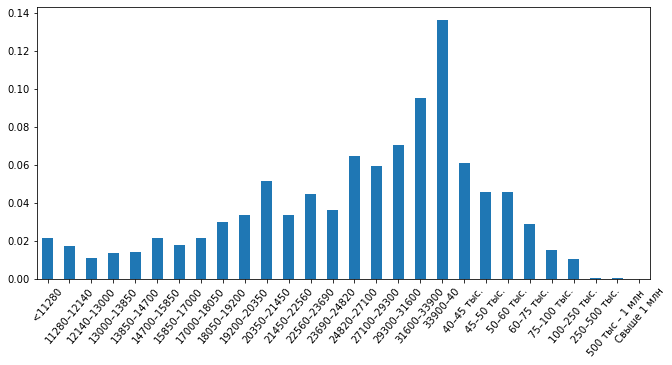

In [20]:
# Распределение изначальных данных
dfk_total.plot(kind = 'bar', rot = 50);

In [21]:
w_default = dfk_total.index.to_list()
q_default = dfk_total.values

In [22]:
import re

w_default = np.array([11280/2, (12140+11280)/2, (12140 + 13000)/2, (13000 +13850)/2, 
                     (13850+14700)/2, (14700+15850)/2, (15850+17000)/2, (17000+18050)/2,
                     (18050+19200)/2, (19200+20350)/2, (20350+21450)/2, (21450+22560)/2,
                     (22560+23690)/2, (23690+24820)/2, (24820+27100)/2, (27100+29300)/2,
                     (29300+31600)/2, (31600+33900)/2, (33900+40_000)/2, (40_000 + 45_000)/2,
                     (45_000+50_000)/2, (50_000+60_000)/2, (60_000+75_000)/2, 
                     (75_000+100_000)/2,
                     (100_000+250_000)/2])
q_default = q_default[:len(w_default)] / sum(q_default[:len(w_default)])

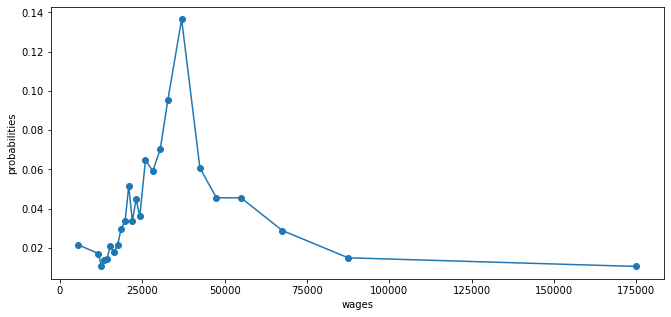

In [23]:
# график распределения усеченного распределения

fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')
plt.show()

In [24]:
# Было удобно переопределить класс, а с ним методы и поля. Не важный блок.

class McCallModel:
    def __init__(self, α, β, c, w=w_default, q=q_default):
        self.α, self.β, self.c, self.w, self.q = α, β, c, w, q
    def update(self, v, d):
        α, β, c, w, q = self.α, self.β, self.c, self.w, self.q
        v_new = np.empty_like(v)
        for i in range(len(w)):
            v_new[i] = u(w[i]) + β * ((1 - α) * v[i] + α * d)
            
        d_new = np.sum(np.maximum(v, u(c) + β * d) * q)
        return v_new, d_new

In [25]:
periods = 100 # living duration
attempts = 100 # number of iterations
max_w, min_w  = max(w_default), min(w_default)
tol = (max_w + min_w)/200 # tolerance

c = 8000 # inital guess of compensation
μ = 0.05; r = 0.043; α=.0 # initial values

result = solving(μ = 0.05, α=α, c = c)
print(f'При вероятности увольнения, равной {α} (то есть мы крепостные):')
print(f'\tРазмер пособия равен {round(result[0], 2)}')
print(f'\tРазмер резервной заработной платы равен {round(result[1], 2)}')
print(f'\tКлючевая ставка равна {round(result[2], 2)}')

При вероятности увольнения, равной 0.0:
	Размер пособия равен 7994.02
	Размер резервной заработной платы равен 24255.0
	Ключевая ставка равна 0.05


            Полученные данные не так плохи. Размер резервной зп похож на реальную (25к), ставка процента = 0.05, что тоже вполне реально. Смущает только размер пособия: слишком похож на начальное значение. Возможно не хватило итераций или я поставил большой tol.

## Тестирование

In [26]:
'''
Все та же функция solving; немного переделано для удобства работы с имеющимися данными
'''

def solving1(α, c, periods = periods, attempts = attempts, tol = tol,
           μ=μ, r=r, step = step):
    
    old_wage = compute_reservation_wage(McCallModel(c=c, β = 1 - (r), α=α))
    attempt, error = 0, np.inf
    old_c = c
    
    while attempt <= attempts and error > tol:
        # движ вправо
        new_c = c + step; 
        r = μ * new_c / old_c 
        β = 1 - (r)
        new_wage = compute_reservation_wage(McCallModel(c=new_c, β=β, α=α))
        diff = new_wage - old_wage
        print(new_wage)
        
        if diff > 0:
            # new_wage > old_wage
            new_c = c - step;
            r = μ * new_c / old_c
            β = 1 - (r)
            print(β)
            new_wage = compute_reservation_wage(McCallModel(c=new_c, β=β, α=α))
            print(new_wage)
            
        if min(new_wage, old_wage) == old_wage:
            step /= 2
        
        error = abs(new_c - c)
        print('wage :', [old_wage, new_wage])
        print('c :', [c, new_c])
        if old_wage == min(old_wage, new_wage):
            pass
        else: 
            c = new_c
        old_wage = min(old_wage, new_wage)
        attempt = attempt + 1
    
    return c, old_wage, r

In [27]:
periods = 100 # 100 периодов наблюдения
r = 0.043 # ключевая ставка в России в 2019 году

'''
Подсчет времени
'''
def solve_model_time(mcm, tol=1e-5, max_iter=periods):
    v = np.ones_like(mcm.w) # Initial guess of v
    d = 1 # Initial guess of d
    i = 0
    error = tol + 1
    while error > tol and i < max_iter:
        v_new, d_new = mcm.update(v, d)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(d_new - d)
        error = max(error_1, error_2)
        v = v_new
        d = d_new
        i += 1
        
    return i

'''
Функция для теста. Проверяем, есть ли сходимость вообще; и если есть, то за сколько шагов.
'''
def testing(mcm, tol=1e-5, max_iter=periods):
    if np.isinf(compute_reservation_wage(mcm)):
        return 'no reserved wage exist for this compensation'
    else: 
        return solve_model_time(mcm, tol=1e-5, max_iter=periods)

In [28]:
c_values = np.linspace(10, 20000, 20)
b_values = [testing(McCallModel(α=0, β=0.043, c=c)) for c in c_values]
data = {'c': c_values, 'b': b_values}
data = pd.DataFrame(data)

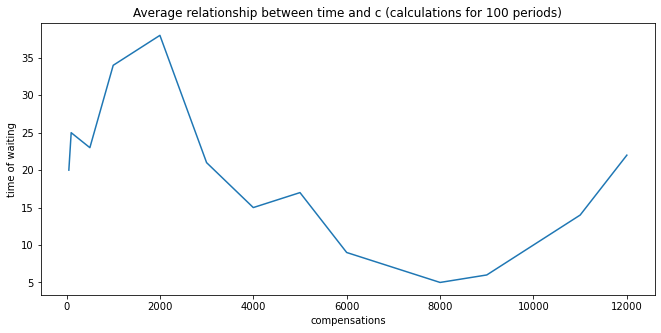

In [29]:
ax = sns.lineplot(data=data, x ='x', y='y')
ax.set(xlabel='compensations', ylabel='time of waiting')
ax.set_title("Average relationship between time and c (calculations for 100 periods)")

plt.show()

Как можно увидеть, выбранный нами размер пособия действительно минимизирует время ожидания работника.

Другой факт правда состоит в том, что, как было отмечено выше, запрет на увольнение в целом не улучшает ситуацию с безработицей. Государству бы стоило задуматься на этот счет.

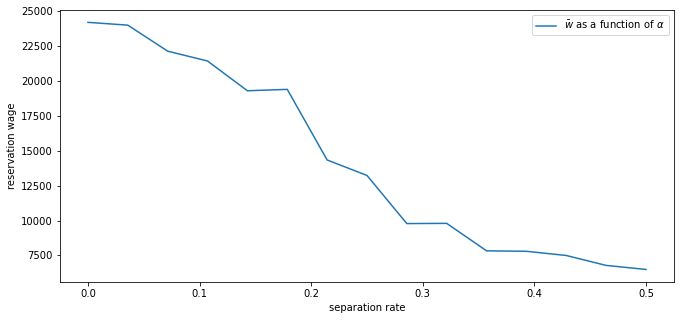

In [30]:
grid_size = 15
c_vals = np.linspace(1000, 10000, grid_size) 
beta_vals = np.linspace(0.8, 0.99, grid_size) 
alpha_vals = np.linspace(0.0, 0.5, grid_size) 

mcm = McCallModel(α=.0, β=0.043, c = 8000)
w_bar_vals = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, α in enumerate(alpha_vals):
    mcm.α = α
    w_bar = compute_reservation_wage(McCallModel(α=α, β=0.043, c = 8000))
    w_bar_vals[i] = w_bar
    
ax.set(xlabel='separation rate', ylabel='reservation wage')
ax.plot(alpha_vals, data.c, label=r'$\bar w$ as a function of $\alpha$')
ax.legend()
plt.show()

## Выводы:

Не успел замутить больше графиков, но большинство итогов все же получено:
1. Мы реализовали простую оптимизацию на основе градиентного спуска, которая помогла нам найти минимум как на синтетических, так и на реальных данных.
2. Показали, что решение получается не всегда. В частности, при некоторых значениях параметров $\alpha$ и $c$.
3. Размер пособия $c$ не полностью обуславливает резервную зп. Поэтому делать его очень маленьким не имеет смысла (это было отражено на графиках).
4. Запрет на увольнения ($\alpha$ = 0) является не лучшей идеей, так как (тоже видно из графика) увеличение вероятности увольнения снижает резервную зп.
5. Полученные результаты по Калусжкой области получились весьма согласованными с эмпирикой. Стоит признаться, что полученные 7994 рубля пособия скорее оказались совпадением, нежели выверенным результатом (до этого получалось и 12 рублей, и 60 тысяч при другом коде). Более того, использовалось truncated распределение, поэтому говорить о полной согласованности нельзя.
6. При этом функция оптимизации дала на искуственных и реальных данных те результаты, которые мы ожидали получить: например, некоторое увеличение вероятности на увольнение все-таки уменьшает уровень $\overline{w}$.
7. Построили график, на котором показали корректность работы алгоритма.

Всем спасибо!